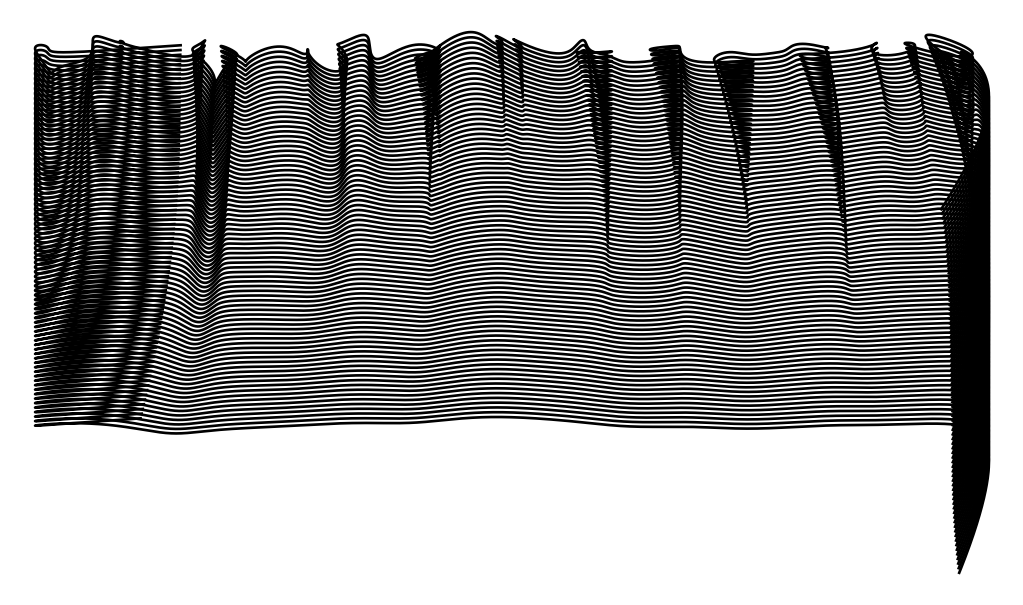

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def make_line(N=1000, sigma_envelope=100, noise_amplitude=0.2, sigma_smooth=10, seed=1):
    """
    Create a horizontally-oriented wavy line:
    1. Start from a straight line of N points.
    2. Add Gaussian noise with strength highest in the middle.
    3. Smooth the derivatives to enforce directional persistence.
    """
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 1, N)
    y = np.zeros_like(x)

    # Gaussian envelope for noise (strongest in center)
    i = np.arange(N)
    center = N // 2
    envelope = np.exp(-0.5 * ((i - center) / sigma_envelope)**2)

    # Add noise
    x_noisy = x + noise_amplitude * envelope * rng.standard_normal(N)
    y_noisy = y + noise_amplitude * envelope * rng.standard_normal(N)

    # Smooth the path directly
    x_smooth = gaussian_filter1d(x_noisy, sigma_smooth, mode="nearest")
    y_smooth = gaussian_filter1d(y_noisy, sigma_smooth, mode="nearest")

    # # Compute derivatives
    # dx = np.gradient(x_smooth)
    # dy = np.gradient(y_smooth)

    # # Smooth the derivatives (directional persistence)
    # dx_s = gaussian_filter1d(dx, sigma_smooth, mode="nearest")
    # dy_s = gaussian_filter1d(dy, sigma_smooth, mode="nearest")

    # # Reintegrate to path
    # x_smooth = np.cumsum(dx_s)
    # y_smooth = np.cumsum(dy_s)

    # Normalize and center
    x_smooth = (x_smooth - x_smooth.min()) / (x_smooth.max() - x_smooth.min())
    y_smooth -= np.mean(y_smooth)

    return x_smooth, y_smooth


# Parameters
N = 10000
sigma_envelope = 1000000
noise_amplitude = 0.3
seed = 6
sigmas = np.geomspace(80, 400, 80)  # smoothing values for each line
spacing = 0.005                    # vertical spacing between lines

# Plot
plt.figure(figsize=(8, 8), dpi=160)
for k, s in enumerate(sigmas):
    x_s, y_s = make_line(
        N,
        sigma_envelope,
        noise_amplitude,
        sigma_smooth=float(s),
        seed=seed
    )
    # Vertical offset and scaling
    y_off = y_s * 0.6 + (len(sigmas)-1 - k) * spacing
    plt.plot(x_s, y_off, linewidth=1.2, color='k')

plt.axis("equal")   # aspect ratio = 1
plt.axis("off")
plt.gca().set_aspect(1.0, adjustable='box')
plt.margins(0.02, 0.03)


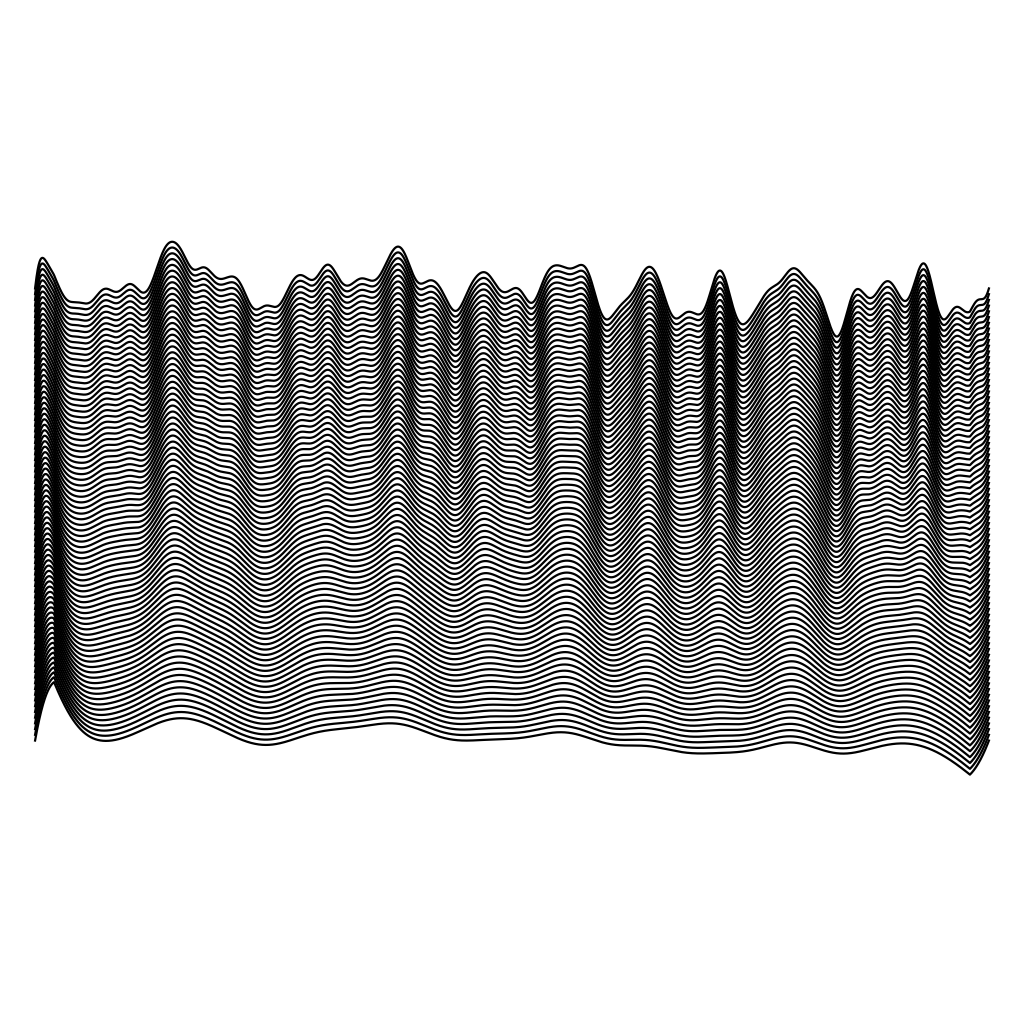

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ==============================
# PARAMETERS
# ==============================
N = 10000            # number of horizontal samples per line
N_LINES = 80         # number of stacked lines
SEED = 6             # random seed for reproducibility
FIGSIZE = (8, 8)     # output figure size
LINE_COLOR = "k"     # color of the lines
LINE_WIDTH = 1.0     # thickness of each line
SPACING = 0.006      # vertical distance between lines

# Noise characteristics
SIGMA_LP = 90       # base low-pass filter for the shared noise field
SIGMA_MIN = 30       # smallest smoothing (top lines = chaotic)
SIGMA_MAX = 300      # largest smoothing (bottom lines = smooth)
AMPLITUDE = 0.35     # overall vertical amplitude scaling
EDGE_FADE = 0.02     # fraction of domain where noise fades to 0 at edges

# Domain warp (for extra chaos)
WARP_SCALE = 0.05    # strength of horizontal warp, set 0 for none
WARP_SIGMA = 100     # smoothness of the warp field

# ==============================
# FUNCTION DEFINITIONS
# ==============================
def bandlimited_noise(N, sigma_lp, seed):
    """Generate 1D Gaussian-filtered white noise."""
    rng = np.random.default_rng(seed)
    n = rng.standard_normal(N)
    return gaussian_filter1d(n, sigma_lp, mode="nearest")

# ==============================
# MAIN CODE
# ==============================
rng = np.random.default_rng(SEED)
x = np.linspace(0, 1, N)
t = np.linspace(0, 1, N)

# Base coherent noise field
base = bandlimited_noise(N, SIGMA_LP, SEED)

# Optional domain warp (creates flow and folds)
warp = WARP_SCALE * bandlimited_noise(N, WARP_SIGMA, SEED + 1)
t_warped = np.clip(t + warp, 0, 1)

# Generate multiple smoothed variants of the same field
sigmas = np.geomspace(SIGMA_MIN, SIGMA_MAX, N_LINES)
ys_all = []
for s in sigmas:
    y = gaussian_filter1d(base, s, mode="nearest")
    # Edge fade for flat ends
    fade = np.ones(N)
    edge = int(EDGE_FADE * N)
    ramp_in = np.linspace(0, 1, edge)
    fade[:edge] = ramp_in
    fade[-edge:] = ramp_in[::-1]
    y *= fade
    ys_all.append(AMPLITUDE * y)

# ==============================
# PLOT
# ==============================
plt.figure(figsize=FIGSIZE, dpi=160)
for k, y in enumerate(ys_all):
    y_off = y + (N_LINES - 1 - k) * SPACING
    plt.plot(x, y_off, color=LINE_COLOR, linewidth=LINE_WIDTH, antialiased=True)

plt.axis("equal")
plt.axis("off")
plt.margins(0.02, 0.03)
plt.show()


In [113]:
# Stacked vertical noise lines with per-line smoothing, optional warp, edge fade,
# and optional occlusion + clipping. Drop-in for your pen-plotter environment.
# Prereqs in your environment: cfg, grbl, penplot_widgets as ppw, Pattern, Polyline, Renderer,
# and a saved rectangle in the widget.

import math, numpy as np, penplot_widgets as ppw
from pattern import Pattern, Polyline, Renderer

# 1) Calibrated rectangle
key   = (round(cfg.x_max, 3), round(cfg.y_max, 3))
state = (getattr(ppw, "_PPW_STATE", {}) or {}).get(key) or {}
BL = state.get("corners", {}).get("BL"); TR = state.get("corners", {}).get("TR")
assert BL and TR, "Calibration rectangle not found. Open the widget and Save Settings."
x0, y0, x1, y1 = float(BL["x"]), float(BL["y"]), float(TR["x"]), float(TR["y"])
W_mm, H_mm = (x1 - x0), (y1 - y0)

# 2) Parameters (mapped from your matplotlib example)
SAMPLES             = 10000   # horizontal samples per line
N_LINES             = 80      # number of stacked lines
SEED                = 6
EDGE_FADE_FRAC      = 0.02    # fraction of domain to fade at edges
AMPLITUDE_FRAC      = 0.35    # of the line spacing used as vertical amplitude

# Spacing and margins in mm
top_bottom_margin_mm = 0.0
line_spacing_mm      = max( (H_mm - 2*top_bottom_margin_mm) / (N_LINES + 1), 0.5 )

# Smoothing schedule (interpreted as kernel radius in samples here)
SIGMA_MIN            = 30
SIGMA_MAX            = 300

# Optional domain warp
WARP_SCALE           = 0.05    # relative units since domain is normalized to [0,1]
WARP_SIGMA           = 100     # smoothing for warp noise (kernel radius)

# Visibility and rendering
use_occlusion        = False   # occlude background lines where a front line is higher
occlusion_gap_mm     = 0.0
clip_to_plane        = True
feed_draw            = 1500
pen_pressure         = -0.15

# 3) Helpers (no SciPy required)
def gaussian_kernel(radius):
    r = int(max(0, round(radius)))
    if r == 0:
        return np.array([1.0], dtype=float)
    x = np.arange(-r, r+1, dtype=float)
    sigma = max(1e-6, r / 3.0)
    k = np.exp(-(x*x)/(2.0*sigma*sigma))
    k /= k.sum()
    return k

def blur_1d(arr, radius, wrap=False):
    r = int(max(0, round(radius)))
    if r == 0:
        return arr
    k = gaussian_kernel(r)
    if wrap:
        a = np.concatenate([arr[-r:], arr, arr[:r]])
        b = np.convolve(a, k, mode="same")
        return b[r:-r]
    else:
        a = np.pad(arr, r, mode="edge")
        b = np.convolve(a, k, mode="same")
        return b[r:-r]

def band_limited_noise(n, sigma_radius, seed):
    rng = np.random.default_rng(seed)
    w = rng.standard_normal(n)
    return blur_1d(w, sigma_radius, wrap=False)

def split_visible_segments(xs, ys, visible_mask):
    segs = []
    n = len(xs)
    i = 0
    while i < n:
        if not visible_mask[i]:
            i += 1
            continue
        j = i + 1
        while j < n and visible_mask[j]:
            j += 1
        segs.append(list(zip(xs[i:j], ys[i:j])))
        i = j
    return segs

def inside_rect_mask(xs, ys, x0, y0, x1, y1):
    return (xs >= x0) & (xs <= x1) & (ys >= y0) & (ys <= y1)

# 4) Prepare normalized domain and shared fields
rng = np.random.default_rng(SEED)
u = np.linspace(0.0, 1.0, SAMPLES)  # normalized horizontal parameter

# Base coherent noise field (low-pass via blur radius SIGMA_LP ~= 90 in the matplotlib code)
SIGMA_LP = 90
base = band_limited_noise(SAMPLES, SIGMA_LP, SEED)

# Optional domain warp (smooth noise) applied before per-line smoothing
warp_raw = band_limited_noise(SAMPLES, WARP_SIGMA, SEED+1)
warp = WARP_SCALE * warp_raw
u_warped = np.clip(u + warp, 0.0, 1.0)
idx = np.linspace(0.0, 1.0, SAMPLES)
base_warped = np.interp(u_warped, idx, base)

# Edge fade for flat ends
edge = int(EDGE_FADE_FRAC * SAMPLES)
fade = np.ones(SAMPLES, dtype=float)
if edge > 0:
    ramp = np.linspace(0.0, 1.0, edge)
    fade[:edge] = ramp
    fade[-edge:] = ramp[::-1]

# Per-line smoothing schedule
sigmas = np.geomspace(SIGMA_MIN, SIGMA_MAX, N_LINES)

# 5) Build lines in mm
lines = []  # list of (x_mm, y_mm) arrays
x_mm = x0 + u * W_mm
amplitude_mm = AMPLITUDE_FRAC * line_spacing_mm

for k, s in enumerate(sigmas):
    # Smooth the warped base with a per-line radius s
    y = blur_1d(base_warped, s, wrap=False)
    y = y * fade
    y_mm = y * amplitude_mm + (y0 + top_bottom_margin_mm + (N_LINES - 1 - k) * line_spacing_mm)
    lines.append((x_mm.copy(), y_mm))

# 6) Visibility and clipping
pat = Pattern()

if use_occlusion:
    # Maintain a silhouette of the maximum drawn y so far at each x-sample.
    # Draw from back to front: first the lowest y_base lines, then toward the viewer (higher y).
    # Our construction already orders from back (k=0, bottom) to front (k=N_LINES-1, top).
    silhouette = np.full(SAMPLES, -np.inf, dtype=float)

    for x, y in lines:
        # Visible where current y is above the silhouette by a gap
        vis = (y >= (silhouette + occlusion_gap_mm))
        if clip_to_plane:
            vis &= inside_rect_mask(x, y, x0, y0, x1, y1)

        segs = split_visible_segments(x, y, vis)
        for seg in segs:
            if len(seg) >= 2:
                pat.add(Polyline(pts=seg, pen_id=0, feed_draw=feed_draw, pen_pressure=pen_pressure))

        # Update silhouette after the whole line, at the same discrete samples
        silhouette = np.maximum(silhouette, y)

else:
    # No occlusion, only clipping
    for x, y in lines:
        vis = np.ones_like(x, dtype=bool)
        if clip_to_plane:
            vis &= inside_rect_mask(x, y, x0, y0, x1, y1)

        segs = split_visible_segments(x, y, vis)
        for seg in segs:
            if len(seg) >= 2:
                pat.add(Polyline(pts=seg, pen_id=0, feed_draw=feed_draw, pen_pressure=pen_pressure))

# 7) Render
r = Renderer(
    grbl,
    z_mode="threshold",
    z_threshold=0.1,
    settle_down_s=0.15,
    settle_up_s=0.15,
    z_step=0.015,
    z_step_delay=0.00,
    flush_every=400,
    feed_travel=3000,
    lift_delta=0.4,
)
r.plot(pat)


ModuleNotFoundError: No module named 'ipycanvas'